# Task Overview

Your task will be to implement a variant of *ProxyProp* (Proximal Backpropagation) – a modification of backpropagation in which the weights of the network are not updated according to gradient descent, but according to [proximal mapping operator](https://en.wikipedia.org/wiki/Proximal_operator). This proximal operator in many cases results in a descent that is quicker than in the case of traditional gradient descent. Interestingly enough, the proximal operator arose in the context of gradient descent in which the minimized function is not differentiable, and gradient descent cannot be applied directly as we cannot compute the Jacobi matrix. This method is called [proximal gradient method](https://en.wikipedia.org/wiki/Proximal_gradient_method). However, we are interested here in the efficiency of the approach rather than its robustness. The backpropagation method in the proximal approach (i.e. *ProxyProp* algorithm) is described in detail in [this paper](https://arxiv.org/pdf/1706.04638v3).

The original algorithm presented in the paper uses purely linear transformations between subsequent network layers. Part of your task is to use affine transformations there, i.e. ones with biases.

You should use an MLP architecture trained on the MNIST dataset. You should implement the network in numpy.

Tasks:
1. (9pt) Fill missing code below
  - 1pt implement the `__init__` method
  - 2pt implement the feedforward method
  - 6pt implement the backpropagation
2. Train the models (find proper hyperparameters). Visualize the learning speed of your best model compared with the standard backpropagation (plot training loss for subsequent numbers of epochs using both algorithms). Your model should reach at least 94% accuracy. Use ClearML to log your scores. Make a comparison of memory usage for _ProxProp_ network and the network you implemented in lab 3.
  - 1pt for accuracy above 94%
  - 1pt for initialization of the standard backpropagation and ProxyProp with the same random values
  - 1pt for visualizations (we recommend downloading plots from clear ml)
  - 2pt if [clear ml](https://clear.ml/docs/latest/docs/) used properly
  - 1pt for comparing memory usage.

Part of the assignment consists of deriving proper formulas for a proposed slight modification of _ProxProp_. We do not grant points separately for this activity. You are rewarded for that only after proper implementation.


## Potential questions, clarifications
- Q: Can I modify code of _ProxyProp_ outside #Your code goes here # to include logging?
  - Yes, in ProxyProp.SGD
- Q: Can I modify the code of _Network_ to include logging?
  - Yes.

In [1]:
%pip install clearml
%pip install memory-profiler
%pip install torchvision

In [2]:
import numpy as np
from clearml import Logger
from typing import List

In [3]:
%load_ext memory_profiler

# Dataset loading


In [4]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

--2024-11-18 21:24:15--  https://s3.amazonaws.com/img-datasets/mnist.npz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.15.176.197, 54.231.233.224, 16.182.36.248, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.15.176.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘mnist.npz’

mnist.npz           100%[===================>]  10.96M  15.9MB/s    in 0.7s    

2024-11-18 21:24:16 (15.9 MB/s) - ‘mnist.npz’ saved [11490434/11490434]



In [5]:
def load_mnist(path: str = "mnist.npz"):
    with np.load(path) as f:
        x_train, _y_train = f["x_train"], f["y_train"]
        x_test, _y_test = f["x_test"], f["y_test"]

    x_train = x_train.reshape(-1, 28 * 28) / 255.0
    x_test = x_test.reshape(-1, 28 * 28) / 255.0

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1

    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)


(x_train, y_train), (x_test, y_test) = load_mnist()

# Set up clear ml

In [12]:
# ### Your code goes here ###
from clearml import Task
import os

%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
# deleted api keys
###########################

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml


# A quick recap of the backpropagation model

## Forward pass

We begin with $g^{(0)} = x$.

To apply forward pass, use the following formulas L times:

$$
%\begin{equation}
f^{(l + 1)} = W^{(l+1)} g^{(l)} + b^{(l+1)}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
g^{(l)} = \sigma(f^{(l)})
\nonumber
%\end{equation}
%\\
$$

$l = 1, 2, \ldots, L$.


Then, use output of the network is $g^{(L)}$ to compute the loss $L(y, g^{(L)})$.

## Backward pass

We begin with $\frac{\partial L}{\partial g^{(L)}}$, which can be computed directly.

To compute gradients, use the following formulas:

$$
%\begin{equation}
\frac{\partial L}{\partial f^{(l)}} = \frac{\partial L}{\partial g^{(l)}} \odot g^{(l)} \odot (1 - g^{(l)})
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial g^{(l)}} = (W^{(l+1)})^{T} \cdot \frac{\partial L}{\partial f^{(l+1)}}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial b^{(l)}} = \frac{\partial L}{\partial f^{(l)}}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial W^{(l)}} = \frac{\partial L}{\partial f^{(l)}} \cdot g^{(l-1)}
\nonumber
%\end{equation}
$$

$l = L, L-1, \ldots, 1$.

# Network definition (as in laboratory 3)


In [8]:
def sigmoid(z: np.ndarray) -> float:
    return 1.0 / (1.0 + np.exp(-z))


def logloss(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    return -(np.log(x) * y).sum() / y.shape[1]

In [9]:
class Network(object):
    def __init__(
        self,
        sizes: List[int],
    ) -> None:
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(
        self,
        a: np.ndarray,
    ) -> np.ndarray:
        # Run the network on a batch
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a) + b)
        return a

    def update_mini_batch(
        self,
        mini_batch: tuple[np.ndarray, np.ndarray],
        eta: float,
    ):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch which is as in tensorflow API.
        # eta is the learning rate
        nabla_b, nabla_w, loss = self.backprop(mini_batch[0].T, mini_batch[1].T)

        self.weights = [
            w - (eta / len(mini_batch[0])) * nw for w, nw in zip(self.weights, nabla_w)
        ]
        self.biases = [
            b - (eta / len(mini_batch[0])) * nb for b, nb in zip(self.biases, nabla_b)
        ]
        return loss

    def backprop(
        self,
        x: np.ndarray,
        y: np.ndarray,
    ) -> tuple[np.ndarray, np.ndarray, float]:
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases, second over weights.
        g = x
        gs = [g]  # list to store all the gs, layer by layer
        fs = []  # list to store all the fs, layer by layer
        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g) + b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)
        # backward pass <- both steps at once
        loss = logloss(gs[-1], y)
        dLdg = self.cost_derivative(gs[-1], y)
        dLdfs = []
        for w, g in reversed(list(zip(self.weights, gs[1:]))):
            dLdf = np.multiply(dLdg, np.multiply(g, 1 - g))
            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)

        dLdWs = [np.matmul(dLdf, g.T) for dLdf, g in zip(reversed(dLdfs), gs[:-1])]
        dLdBs = [
            np.sum(dLdf, axis=1).reshape(dLdf.shape[0], 1) for dLdf in reversed(dLdfs)
        ]
        return (dLdBs, dLdWs, loss)

    def evaluate(
        self,
        test_data: tuple[np.ndarray, np.ndarray],
    ) -> float:
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]), axis=0)
        corr = np.argmax(test_data[1], axis=1).T
        return np.mean(pred == corr)

    def cost_derivative(
        self,
        output_activations: np.ndarray,
        y: np.ndarray,
    ) -> np.ndarray:
        return output_activations - y

    def SGD(
        self,
        training_data: np.ndarray,
        epochs: int,
        mini_batch_size: int,
        eta: float,
        test_data: np.ndarray = None,
        logger: Logger = None,
    ) -> None:
        x_train, y_train = training_data
        ifx_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        wloss = logloss(self.feedforward(x_train).T, y_train) / (
            x_train.shape[0] // mini_batch_size
        )
        for j in range(epochs + 1):
            if logger is not None:
                logger.report_scalar(
                    title="Training Loss", series="Basic Network", iteration=j, value=wloss
                )
            if test_data:
                acc = self.evaluate((x_test, y_test))
                if logger is not None:
                    logger.report_scalar(
                        title="Test Set Accuracy",
                        series="Basic Network",
                        iteration=j,
                        value=acc,
                    )
                print("Epoch: {0}, Accuracy: {1}, Loss: {2}".format(j, acc, wloss))
            else:
                print("Epoch: {0}".format(j))
            if j == epochs:
                break
            loss = 0
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                y_mini_batch = y_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                loss += self.update_mini_batch((x_mini_batch, y_mini_batch), eta)
            wloss = loss / (x_train.shape[0] // mini_batch_size)



# Simple check if all is fine
network = Network([784, 30, 30, 10])
network.SGD(
    (x_train, y_train),
    epochs=2,
    mini_batch_size=100,
    eta=3.0,
    test_data=(x_test, y_test),
)

Epoch: 0, Accuracy: 0.0891, Loss: 16.53392446636228
Epoch: 1, Accuracy: 0.7795, Loss: 1.8644988885914024
Epoch: 2, Accuracy: 0.8539, Loss: 0.6509972859882457


# The original ProxProp definition

Let us fix the notation for our network as in the following figure. We can see here a series of layers with $n_0,\ldots, n_{L-2}$ nodes. Each layer is composed of input nodes that depend linearly ($\phi$ operator) on the output nodes that depend non-linearly on the respective input nodes ($\sigma$ operator). The quality of the final output is measured by the final loss function ${\cal L}_y$ (typically $\frac{1}{2}\|\cdot\|^2$).




![image.png]( 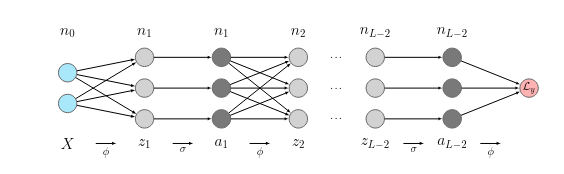)

_ProxProp_ procedure itself works similarly to a standard backpropagation procedure, as shown in the following figure.


![image.png]( 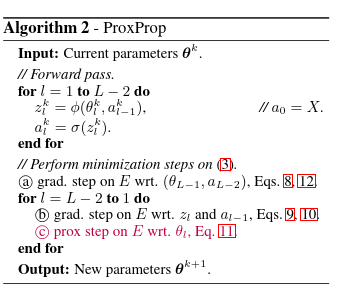)

For comparison, the standard backpropagation algorithm in this setting is as follows:


![image.png]( 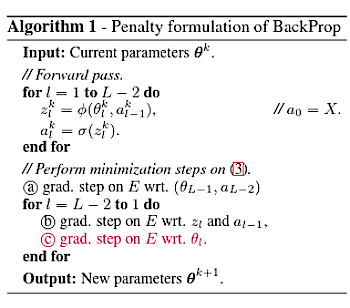)

Forward: The forward propagation phase is just as in the standard algorithm:

$z^k_l = \phi(\theta^k_l, a^k_{l−1}),$

$a^k_l = \sigma(z^k_l),$

where $\phi$ is supposed to be a linear transformation with weights $\theta^k_l$ over values $a^k_{l-1}$ and $\sigma$ is some non-linear step, e.g. the sigmoid function or the LeRU. You can use the sigmoid function for the purposes of this work.

Reverse: In the backpropagation, the step for the final layer ((a) on the figure) is exactly as in the gradient based version. In steps for the earlier layers, we recompute the z's and a's using the gradient method ((b) on the figure), but the weights are computed according to the proximal operator ((c) on the figure).

In step (a) the updated value is

$a'^{k}_{L−2} = a^k_{L−2} − \eta\nabla_{a_{L−2}} {\cal L}_y(\phi(\theta_{L−1}, a_{L−2})),$

where $\eta$ is the learning speed coefficient.

In case (b) the updated values are

$z'^{k}_l = z^k_l − \sigma'(z^k_l)(\sigma(z^k_l) − a'^k_l),$

$a'^{k}_{l−1} = a^k_{l−1} − \nabla( \frac{1}{2}\| \phi(θ^l, \cdot) − z'^k_l \|^2)(a^k_{l−1}),$

Note that the primed $a$-values are used to compute primed $z$-values and primed $z$-values are used to obtain the final value of $\theta^{k+1}$.

In case (c) the updated values are computed according to the proximal formula:

$$
\theta^{k+1}_l = \underset{\gamma}{\mathrm{argmin}} \left(\frac{1}{2} \|\phi(\gamma, a^k_{l−1}) − z'^k_l\|^2 + \frac{1}{2\tau_\theta}\|\gamma - \theta^k_l\|^2\right)
$$

The computation for the final layer is not done according to the proximity formula as it is difficult to obtain the closed formula for the necessary update, therefore it should be done according to the standard gradient descent.

The original formulas from the mentioned above paper do not use the biases. Part of the assignment is to rework this method so that the formulas include biases. You should develop a method in which biases are updated using the standard gradient descent method and the linear weight are updated using the _PropProx_ method with formulas adjusted to accommodate for biases.

# ProxProp similar to our backpropagation

Your task is to implement algorithm based on [ProxProp](https://arxiv.org/pdf/1706.04638v3). Please refer to the section above or section 4.2 in [the paper](https://arxiv.org/pdf/1706.04638v3) for algorithm description. Here we present the overview of the algorithm to be implemented.

## Forward pass

Forward pass is the same as in backpropagation implementation used in this course:
We begin with $g^{(0)} = x$.

To apply forward pass, use the following formulas L times:

$$
%\begin{equation}
f^{(l + 1)} = W^{(l+1)} g^{(l)} + b^{(l+1)}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
g^{(l)} = \sigma(f^{(l)})
\nonumber
%\end{equation}
%\\
$$

$l = 1, 2, \ldots, L$.


Then, use output of the network is $g^{(L)}$ to compute the loss $L(y, g^{(L)})$.

## Backward pass

We begin with $\frac{\partial L}{\partial g^{(L)}}$, which can be computed directly.

Gradients $\frac{\partial L}{\partial f^{(l)}}$, $\frac{\partial L}{\partial g^{(l)}}$ need to be computed.

$$
%\begin{equation}
\frac{\partial L}{\partial f^{(l)}} = \frac{\partial L}{\partial g^{(l)}} \odot g^{(l)} \odot (1 - g^{(l)})
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial g^{(l)}} = (W^{(l+1)})^{T} \cdot \frac{\partial L}{\partial f^{(l+1)}}
\nonumber
%\end{equation}
$$

For simplicity, biases will be updated as in standard backpropagation:
$$
%\begin{equation}
b^{(l)} = b^{(l)} - \eta \frac{\partial L}{\partial b^{(l)}}
\nonumber
%\end{equation}
$$
Remember to make the gradient update independent from the batch size by appropriate averaging!

Weights will be updated using values $f^{(l)}_{*}, g^{(l)}_{*}$. They are defined as follows:

$$
%\begin{equation}
g^{(L)}_{*} = g^{(L)} - \eta \frac{\partial L}{\partial g^{(L)}}
%\end{equation}
$$

$$
%\begin{equation}
f^{(l)}_{*} = f^{(l)} - \frac{\partial g^{(l)}}{\partial f^{(l)}} \cdot (g^{(l)} - g^{(l)}_{*})
%\end{equation}
$$

$l = 1, 2, \ldots, L$.

$$
%\begin{equation}
g^{(l)}_{*} = g^{(l)} - \frac{\partial f^{(l+1)}}{\partial g^{(l)}} \cdot (f^{(l+1)} - f^{(l+1)}_{*})
%\end{equation}
$$

$l = 1, 2, \ldots, L - 1$.

 The update of weights is defined as:

$$
%\begin{equation}
W^{(l)} = \text{arg min}_{W} \frac{1}{2} || W \cdot g^{(l-1)} + b^{(l)} - f^{(l)}_{*} ||^2 + \frac{1}{2\eta} || W - W^{(l)} ||^2
%\end{equation}
$$

$l = 1, 2, \ldots, L$.

Remarks:
* Weights are updated last (This means updated $b^{(l)}$ is used in the formula above).
* Please use closed form of the update assuming $W$ is a matrix. It might involve inverting some matrix. While it is not desirable in practice, the aim of this homework is to make you come up with the formula for the update :)
* Note that the original algorithm used two eta values. For the homework you should assume that these are equal and use for that only one parameter of the network.

In [10]:
class ProxProp(object):
    def __init__(
        self,
        sizes: List[int],
    ) -> None:
        self.sizes = sizes
        self.num_layers = len(sizes)
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(
        self,
        a: np.ndarray,
    ) -> np.ndarray:
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a) + b)
        return a

    def backprop(self, x: np.ndarray, y: np.ndarray, eta: float) -> float:
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases,  second over weights.
        g = x
        gs = [g]  # list to store all the gs, layer by layer
        fs = []  # list to store all the fs, layer by layer
        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g) + b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)
        # backward pass <- both steps at once
        dLdBs = []
        dLdWs = []
        loss = logloss(gs[-1], y)
        dLdg = self.cost_derivative(gs[-1], y)
        g_star = gs[-1]  - eta * dLdg
        dLdfs = []
        for w, g, f, g_l_minus_1, b in reversed(list(zip(self.weights, gs[1:], fs, gs[:-1], self.biases))):
            f_star = f - g * (1 - g) * (g - g_star)
            dLdf = np.multiply(dLdg, np.multiply(g, 1 - g))
            dLdBs.append(np.sum(dLdf, axis=1).reshape(dLdf.shape[0], 1))
            A_t = g_l_minus_1.T
            ss =  g_l_minus_1 @ g_l_minus_1.T
            inversed = np.linalg.inv(ss +  1 / eta * np.eye(ss.shape[0]))
            dldW = ((f_star - b) @ A_t + 1/eta * w) @ inversed
            dLdWs.append(dldW)
            g_star =  g_l_minus_1 - w.T @ (f - f_star)
            dLdg = np.matmul(w.T, dLdf)


        return (reversed(dLdBs), reversed(dLdWs), loss)

    def evaluate(
        self,
        test_data: tuple[np.ndarray, np.ndarray],
    ) -> float:
        pred = np.argmax(self.feedforward(test_data[0]), axis=0)
        corr = np.argmax(test_data[1], axis=1).T
        return np.mean(pred == corr)

    def cost_derivative(
        self,
        output_activations: np.ndarray,
        y: np.ndarray,
    ) -> np.ndarray:
        return output_activations - y

    def SGD(
        self,
        training_data: np.ndarray,
        epochs: int,
        mini_batch_size: int,
        eta: float,
        test_data: np.ndarray = None,
        logger: Logger = None,
    ) -> None:
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        wloss = logloss(self.feedforward(x_train).T, y_train) / (
            x_train.shape[0] // mini_batch_size
        )
        for j in range(epochs + 1):
            if logger is not None:
                logger.report_scalar(
                    title="Training Loss", series="ProxyProp", iteration=j, value=wloss
                )
            if test_data:
                acc = self.evaluate((x_test, y_test))
                if logger is not None:
                    logger.report_scalar(
                        title="Test Set Accuracy",
                        series="ProxyProp",
                        iteration=j,
                        value=acc,
                    )
                print("Epoch: {0}, Accuracy: {1}, Loss: {2}".format(j, acc, wloss))
            else:
                print("Epoch: {0}".format(j))
            if j == epochs:
                break
            loss = 0
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                y_mini_batch = y_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                (nabla_b, nabla_w, loss_1) = self.backprop(x_mini_batch.T, y_mini_batch.T, eta)
                self.weights = [
                  nw for w, nw in zip(self.weights, nabla_w)
                ]
                self.biases = [
                    b - (eta / mini_batch_size) * nb for b, nb in zip(self.biases, nabla_b)
                ]
                loss += loss_1
            wloss = loss / (
                x_train.shape[0] // mini_batch_size
            )  # we compute the average of the losses over the number of minibatches



# Simple check if all is fine
network = ProxProp([784, 30, 30, 10])
network.SGD(
    (x_train, y_train),
    epochs=2,
    mini_batch_size=100,
    eta=3.0,
    test_data=(x_test, y_test),
)

Epoch: 0, Accuracy: 0.0975, Loss: 10.573440665856532
Epoch: 1, Accuracy: 0.8705, Loss: 0.8040648155742591
Epoch: 2, Accuracy: 0.9053, Loss: 0.4350179185219459


# Train the network

In [ ]:
### Your code goes here ###
# checked and learning rates < 1 doesnt work well
import itertools
seed = 42
learning_rates = [1.0, 5.0, 10.0]
batch_sizes = [100,200]
epochs_count = 10
layers = [[784, 100, 30, 10], [784, 128, 64, 32, 10], [784, 30, 10]]

info = []
for hyperparams in itertools.product(learning_rates, batch_sizes, layers):
    lr, bsize, layer = hyperparams
    np.random.seed(seed)
    network = ProxProp(layer)
    # Train the network with the specified hyperparameters
    network.SGD(
        (x_train, y_train),
        epochs=epochs_count,
        mini_batch_size=bsize,
        eta=lr,
        test_data=(x_test, y_test),
    )
    acc = network.evaluate((x_test, y_test))
    print(f"accuracy achieved = {acc} for learning rate = {lr}, batch size = {bsize} and layers shape = {layer}")
    info.append((acc,lr,bsize,layer))


###########################

Epoch: 0, Accuracy: 0.0612, Loss: 23.423901327875438
Epoch: 1, Accuracy: 0.7435, Loss: 1.6838817698943545
Epoch: 2, Accuracy: 0.8505, Loss: 0.909705033217238
Epoch: 3, Accuracy: 0.8818, Loss: 0.5178181568757341
Epoch: 4, Accuracy: 0.8963, Loss: 0.43775806187624067
Epoch: 5, Accuracy: 0.9053, Loss: 0.3936464476066912
Epoch: 6, Accuracy: 0.9105, Loss: 0.3631922818569246
Epoch: 7, Accuracy: 0.913, Loss: 0.33958545944883145
Epoch: 8, Accuracy: 0.9172, Loss: 0.3203161762965228
Epoch: 9, Accuracy: 0.9198, Loss: 0.30434906113548543
Epoch: 10, Accuracy: 0.9204, Loss: 0.2909958984432556
accuracy achieved = 0.9204 for learning rate = 1.0, batch size = 100 and layers shape = [784, 100, 30, 10]
Epoch: 0, Accuracy: 0.0898, Loss: 27.883328019047124
Epoch: 1, Accuracy: 0.699, Loss: 2.7729182619877677
Epoch: 2, Accuracy: 0.7312, Loss: 2.428058596958999
Epoch: 3, Accuracy: 0.7449, Loss: 2.3515258428956938
Epoch: 4, Accuracy: 0.7522, Loss: 2.308317644332593
Epoch: 5, Accuracy: 0.756, Loss: 2.27691004351

In [ ]:
for acc, lr, bsize, layer in info:
    print(f"accuracy achieved = {acc} for learning rate = {lr}, batch size = {bsize} and layers shape = {layer}")

accuracy achieved = 0.9204 for learning rate = 1.0, batch size = 100 and layers shape = [784, 100, 30, 10]
accuracy achieved = 0.7628 for learning rate = 1.0, batch size = 100 and layers shape = [784, 128, 64, 32, 10]
accuracy achieved = 0.912 for learning rate = 1.0, batch size = 100 and layers shape = [784, 30, 10]
accuracy achieved = 0.9117 for learning rate = 1.0, batch size = 200 and layers shape = [784, 100, 30, 10]
accuracy achieved = 0.7606 for learning rate = 1.0, batch size = 200 and layers shape = [784, 128, 64, 32, 10]
accuracy achieved = 0.9019 for learning rate = 1.0, batch size = 200 and layers shape = [784, 30, 10]
accuracy achieved = 0.9391 for learning rate = 5.0, batch size = 100 and layers shape = [784, 100, 30, 10]
accuracy achieved = 0.8516 for learning rate = 5.0, batch size = 100 and layers shape = [784, 128, 64, 32, 10]
accuracy achieved = 0.9335 for learning rate = 5.0, batch size = 100 and layers shape = [784, 30, 10]
accuracy achieved = 0.9286 for learning r

# Training plots for the best training

In [11]:
### Your code goes here ###
# best accuracy in hyperparameters search with 10 epochs:
# accuracy achieved = 0.943 for learning rate = 10.0, batch size = 100 and layers shape = [784, 100, 30, 10]
# runned 50 epochs and checked that it stops learning after about 15/20 so setting epochs = 20
# even in 20 epochs it converges quicker but I decided to stay with 20 to have more points to log in ClearML
# It is important to note that color of line for ProxProp could not be changed on clearML dashboard - using changing color did not update the plot
# therefore the line for ProxProp is barely visble but it exists on both plots
# the plots

task = Task.init(project_name="ProxProp vs Basic Network", task_name="ProxProp")
lr = 10
batch_size = 100
layer_shape = [784, 100, 30, 10]
seed = 42
epochs_number = 20

np.random.seed(seed)
loggerP = task.get_logger()
networkP = ProxProp(layer_shape)
networkP.SGD(
    (x_train, y_train),
    epochs=epochs_number,
    mini_batch_size=batch_size,
    eta=lr,
    test_data=(x_test, y_test),
    logger=loggerP
)

np.random.seed(seed)
logger = task.get_logger()
network = Network(layer_shape)
network.SGD(
    (x_train, y_train),
    epochs=epochs_number,
    mini_batch_size=batch_size,
    eta=lr,
    test_data=(x_test, y_test),
    logger=logger
)

task.close()

###########################
# it turns out that standard network achieves higher accuracy

ClearML Task: overwriting (reusing) task id=496641b5d8e64dc493bdfb62c63334d1
2024-11-18 21:26:49,028 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/152fa1566bf54f748248f661a2d71b03/experiments/496641b5d8e64dc493bdfb62c63334d1/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
Epoch: 0, Accuracy: 0.0612, Loss: 23.423901327875438
Epoch: 1, Accuracy: 0.9003, Loss: 0.7677490183002804
Epoch: 2, Accuracy: 0.922, Loss: 0.40763525502660214
Epoch: 3, Accuracy: 0.9297, Loss: 0.33526442906816983
Epoch: 4, Accuracy: 0.9339, Loss: 0.3061121668480259
Epoch: 5, Accuracy: 0.9359, Loss: 0.2828424493766253
Epoch: 6, Accuracy: 0.9385, Loss: 0.2693462216823553
Epoch: 7, Accuracy: 0.938, Loss: 0.2460936440069339
Epoch: 8, Accuracy: 0.9428, Loss: 0.24159365358934778
Epoch: 9, Accuracy: 0.9394, Loss: 0.22724910323798264
Epoch: 10, Accuracy: 0.943, Loss: 0.2198629827216473
Epoch: 11, Accurac

# Compare memory usage

Hint: you can use memory-profiler library [link](https://pypi.org/project/memory-profiler/)

In [ ]:
### Your code goes here ###

from memory_profiler import memory_usage

def ProxPropFun():
  np.random.seed(seed)
  loggerP = task.get_logger()
  networkP = ProxProp(layer_shape)
  networkP.SGD(
      (x_train, y_train),
      epochs=epochs_number,
      mini_batch_size=batch_size,
      eta=lr,
      test_data=(x_test, y_test),
      logger=loggerP
  )

def StandardNetworkFun():
  np.random.seed(seed)
  logger = task.get_logger()
  network = Network(layer_shape)
  network.SGD(
      (x_train, y_train),
      epochs=epochs_number,
      mini_batch_size=batch_size,
      eta=lr,
      test_data=(x_test, y_test),
      logger=logger
  )

m1 = memory_usage(StandardNetworkFun)

m2 = memory_usage(ProxPropFun)
###########################

Epoch: 0, Accuracy: 0.0612, Loss: 23.423901327875438
Epoch: 1, Accuracy: 0.7129, Loss: 3.702695279836879
Epoch: 2, Accuracy: 0.7393, Loss: 2.2316071210237536
Epoch: 3, Accuracy: 0.8391, Loss: 1.3705667697920738
Epoch: 4, Accuracy: 0.9263, Loss: 0.3582199943044588
Epoch: 5, Accuracy: 0.9354, Loss: 0.2832927854661953
Epoch: 6, Accuracy: 0.9378, Loss: 0.2560993720776809
Epoch: 7, Accuracy: 0.9407, Loss: 0.23751594688426322
Epoch: 8, Accuracy: 0.9427, Loss: 0.22349391531409438
Epoch: 9, Accuracy: 0.9431, Loss: 0.21130101822549952
Epoch: 10, Accuracy: 0.9441, Loss: 0.20147605194347556
Epoch: 11, Accuracy: 0.9468, Loss: 0.19300092694328488
Epoch: 12, Accuracy: 0.9476, Loss: 0.18520797247494888
Epoch: 13, Accuracy: 0.9491, Loss: 0.17759328250795034
Epoch: 14, Accuracy: 0.9492, Loss: 0.17149811719359215
Epoch: 15, Accuracy: 0.9501, Loss: 0.16655318087231938
Epoch: 16, Accuracy: 0.9505, Loss: 0.16110043047562944
Epoch: 17, Accuracy: 0.9512, Loss: 0.1566424459150075
Epoch: 18, Accuracy: 0.953, L

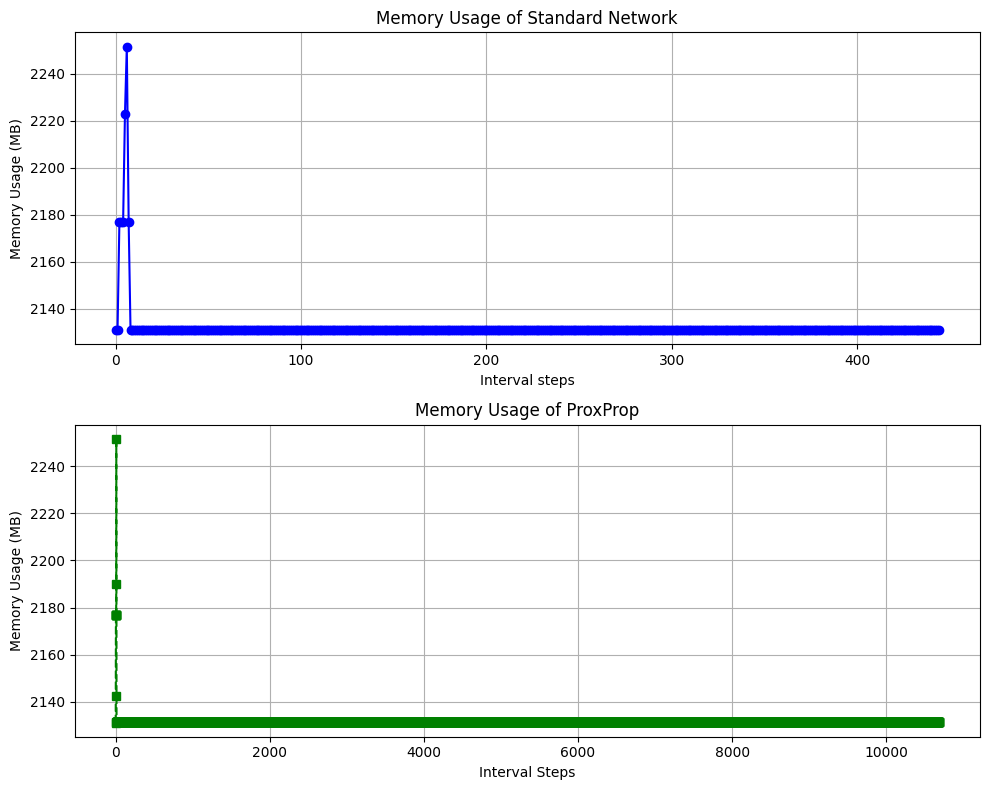

In [ ]:
import matplotlib.pyplot as plt
# running memory comparison on the same number of epochs as in during final training,
# however since training time of ProxProp is significantly higher we get more data points

x1 = list(range(len(m1)))
x2 = list(range(len(m2)))

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot m1
axs[0].plot(x1, m1, marker='o', color='blue', linestyle='-')
axs[0].set_title('Memory Usage of Standard Network')
axs[0].set_xlabel('Interval steps')
axs[0].set_ylabel('Memory Usage (MB)')
axs[0].grid(True)

# Plot m2
axs[1].plot(x2, m2, marker='s', color='green', linestyle='--')
axs[1].set_title('Memory Usage of ProxProp')
axs[1].set_xlabel('Interval Steps')
axs[1].set_ylabel('Memory Usage (MB)')
axs[1].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# as visible below the memory usage is similar throughout the entire training process in both networks.
# it slightly peaks in the beggining (about 100MB) also in both.
# it makes sense that both networks have similar memory usage since they have the same number of neurons in each layer,
# thus the same number of weights and biases